## Explore Gulf of Tehuantepec extreme wind events and ocean response 

Notebook to read, condition and resample,  and plot various NASA cloud optimized earth science datasets created with virtualizarr 

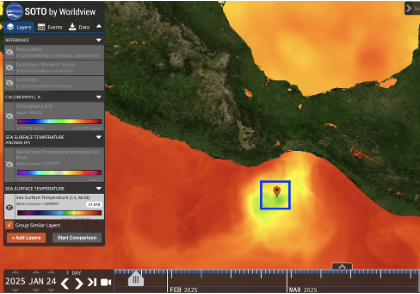

Gulf of Tehuantepec SST response, Jan 2025. Image source: https://worldview.earthdata.nasa.gov/?v=-108.72259017741943,7.33173524018812,-78.34905371495425,20.763067902309658&l=Reference_Labels_15m(hidden),Reference_Features_15m(hidden),Coastlines_15m,GHRSST_L4_MUR_Sea_Surface_Temperature,VIIRS_NOAA21_CorrectedReflectance_TrueColor(hidden),VIIRS_NOAA20_CorrectedReflectance_TrueColor(hidden),VIIRS_SNPP_CorrectedReflectance_TrueColor(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor(hidden)&lg=true&t=2025-01-24-T03%3A09%3A40Z


## Import Packages
#### ***Note using Zarr Version 2***

In [1]:
pip install earthaccess>=0.13.0 zarr==2.18.7 fastparquet>=2024.5.0 xarray==2025.4.0 fsspec>=2024.10.0 "dask[complete]">=2024.5.2 h5netcdf==1.3.0 ujson>=5.10.0 matplotlib>=3.9.2  kerchunk==0.2.7 virtualizarr==1.3.2  cftime cartopy

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.37.38 requires botocore<1.38.0,>=1.37.38, but you have botocore 1.39.8 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip list | grep -E "zarr|xarray|virtualizarr|kerchunk"

kerchunk                  0.2.7
virtualizarr              1.3.2
xarray                    2025.4.0
zarr                      2.18.7
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Built-in packages
import os
import sys

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import xarray as xr
import numpy as np

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client

# Other
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Other Setup

In [4]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Get Data File S3 endpoints in Earthdata Cloud 
The first step is to find the S3 endpoints to the files. Handling access credentials to Earthdata and then finding the endpoints can be done a number of ways (e.g. using the `requests`, `s3fs` packages) but we use the `earthaccess` package for its ease of use. We get the endpoints for all files in the CCMP record.

In [6]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  edward.m.armstrong
Enter your Earthdata password:  ········


In [7]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
#fs = earthaccess.get_s3_filesystem(daac="PODAAC")

# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_fsspec_https_session() 

## 2. Open reference files from S3 bucket

The reference can be saved to file and used to open the corresponding CCMP data file with Xarray:

In [8]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    #storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    storage_opts = {"fo": ref, "remote_protocol": "https", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

### OSTIA Daily Sea Surface Temperature (OSTIA-UKMO-L4-GLOB-REP-v2.0)

In [9]:
%%time

# Open the OSTIA Reprocessed SST reference file (OSTIA-UKMO-L4-GLOB-REP-v2.0)
#sst_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/ghrsst/open/docs/OSTIA-UKMO-L4-GLOB-REP-v2.0_combined-ref.json', fs)
sst_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_https.json', fs)
print(sst_ds)
sst_ds

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (39)
CPU times: user 2.16 s, sys: 459 ms, total: 2.62 s
Wall time: 7.85 s


<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (39)

### CCMP 6 Hourly Ocean Winds (CCMP_WINDS_10M6HR_L4_V3.1)

In [10]:
%%time

# Open the CCMP Winds reference file (CCMP_WINDS_10M6HR_L4_V3.1)
wind_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_WINDS_10M6HR_L4_V3.1_virtual_https.json', fs)

print(wind_ds)
#wind_ds

<xarray.Dataset> Size: 781GB
Dimensions:    (latitude: 720, longitude: 1440, time: 47056)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 376kB 1993-01-02 ... 2025-03-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (44)
CPU times: user 1.18 s, sys: 187 ms, total: 1.37 s
Wall time: 4.62 s


In [11]:
# Determine and append the wind direction to the wind_ds dataset

# Calculate wind direction in degrees using arctan2(-u, -v)
wind_dir = np.arctan2(-wind_ds.uwnd, -wind_ds.vwnd)  # radians
wind_dir = np.degrees(wind_dir)  # convert to degrees
wind_dir = (wind_dir + 360) % 360  # ensure values are between 0 and 360

# Assign to dataset
wind_ds['wind_direction'] = wind_dir
wind_ds['wind_direction'].attrs.update({
    'units': 'degrees',
    'standard_name': 'wind_from_direction',
    'long_name': 'Wind Direction (meteorological)'
})
wind_ds

<xarray.Dataset> Size: 976GB
Dimensions:         (latitude: 720, longitude: 1440, time: 47056)
Coordinates:
  * latitude        (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 6kB 0.125 0.375 0.625 ... 359.6 359.9
  * time            (time) datetime64[ns] 376kB 1993-01-02 ... 2025-03-31T18:...
Data variables:
    nobs            (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd            (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd            (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws              (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    wind_direction  (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (44)

### Region and time window selection

In [12]:
%%time

# Define region
#offshore Monterey Bay, CA as a one degree box 

# Gulf of Tehuantepec, MX
lat_min = 14.
lat_max = 15.
lon_min = -96.
lon_max = -95.

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

# for datasets that use 0-360 deg lon
lon_range_360 = (lon_min+360, lon_max+360)

# Define the time slice 
start_date = '1993-01-01'
end_date = '2002-12-31'
#end_date = '2002-12-31'
time_range =(start_date, end_date)

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 6.44 μs


## Resample spatial SST and Wind Speed means to a common monthly time step and load into memory

In [13]:
%%time

# A concise method to subset, resample, and average the xarray data all on one line
#sst_resample = sst_ds.analysed_sst.sel(lon=slice(*lon_range), lat=slice(*lat_range), time=slice(*time_range)).mean(["lat", "lon"]).resample(time="1ME").mean().load()
#wind_speed_resample = wind_ds.ws.sel(longitude=slice(*lon_range_360), latitude=slice(*lat_range), time=slice(*time_range)).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

sst_resample = sst_ds.analysed_sst.sel(lon=slice(*lon_range), lat=slice(*lat_range), time=slice(*time_range)
).mean(["lat", "lon"]).resample(time="1ME").mean().load()

wind_speed_resample = wind_ds.ws.sel(longitude=slice(*lon_range_360), latitude=slice(*lat_range), time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

CPU times: user 5min 28s, sys: 35.7 s, total: 6min 4s
Wall time: 3min 47s


### Resample the wind directions means to the same common monthly time step and find the favorable wind direction (0-45 deg) times

In [14]:
%%time

# Resample u and v winds (monthly mean)
u_resample = wind_ds.uwnd.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

v_resample = wind_ds.vwnd.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

#  Resample wind direction
wind_dir_resample = wind_ds.wind_direction.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

# Identify favorable wind direction times (0–45 degrees)
favorable_mask = (wind_dir_resample >= 0) & (wind_dir_resample <= 45)
favorable_times = wind_dir_resample.time[favorable_mask]

CPU times: user 23min 46s, sys: 56 s, total: 24min 42s
Wall time: 9min 30s


### Check with a plot 

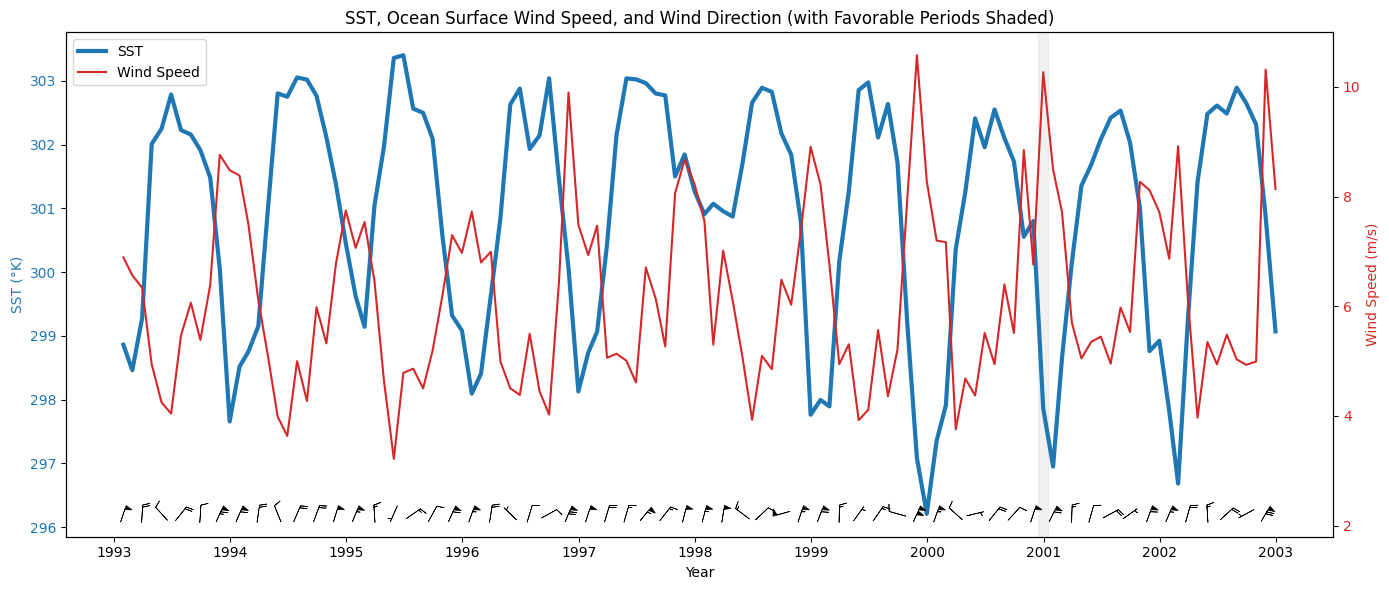

In [18]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# SST Plot
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°K)', color=color)
ax1.plot(sst_resample['time'], sst_resample, linewidth=3, color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color)

# Wind Speed Plot
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wind Speed (m/s)', color=color)
ax2.plot(wind_speed_resample['time'], wind_speed_resample, color=color, label='Wind Speed')
ax2.tick_params(axis='y', labelcolor=color)

# Add vertical shaded regions for favorable wind direction periods
for ft in favorable_times.values:
    ax1.axvspan(ft - np.timedelta64(15, 'D'), ft + np.timedelta64(15, 'D'),
                color='lightgray', alpha=0.3)

# Add wind barbs in lower panel (directional vectors)
# Normalize u and v components for visual length
barb_skip = 2  # Plot every nth point to reduce clutter if needed
barb_scale = 30  # Adjust scale for clarity

# Only plot barbs every few months
barb_time = u_resample.time.values[::barb_skip]
u_plot = u_resample.values[::barb_skip]
v_plot = v_resample.values[::barb_skip]

# Set position for barbs slightly below wind speed line
barb_y = np.full_like(u_plot, wind_speed_resample.min().item() - 1)

# Barbs on ax2 (wind axis)
ax2.barbs(barb_time, barb_y, u_plot, v_plot,
          length=5, pivot='middle', barb_increments=dict(half=1, full=2, flag=5),
          color='k', linewidth=0.5)

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("SST, Ocean Surface Wind Speed, and Wind Direction (with Favorable Periods Shaded)")
fig.tight_layout()
plt.show()

### Use parallel processing to speed the resample() approach

In [21]:
# Set up parallel processing

# Check how many cpu's are on this VM:
print("CPU count =", multiprocessing.cpu_count())

# Start up cluster and print some information about it:
client = Client(n_workers=32, threads_per_worker=1)
print(client.cluster)
#print("View any work being done on the cluster here", client.dashboard_link)

CPU count = 32
LocalCluster(20862c75, 'tcp://127.0.0.1:39617', workers=32, threads=32, memory=122.28 GiB)


In [22]:
%%time

# Execute Tasks: Convert to weekly (1W) monthly (1ME) or annual means (1YE).  
# use load() to load into memory the result
#sst_resample = sst_mean.resample(time="1ME").mean().load()
#wind_speed_resample = wind_speed_mean.resample(time="1ME").mean().load()

# A concise method to subset, resample, and average the xarray data all on one line
sst_resample = sst_ds.analysed_sst.sel(lon=slice(*lon_range), lat=slice(*lat_range), time=slice(*time_range)
).mean(["lat", "lon"]).resample(time="1ME").mean().load()

wind_speed_resample = wind_ds.ws.sel(longitude=slice(*lon_range_360), latitude=slice(*lat_range), time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

u_resample = wind_ds.uwnd.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

v_resample = wind_ds.vwnd.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()


wind_dir_resample = wind_ds.wind_direction.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

# Identify favorable wind direction times (0–45 degrees)
favorable_mask = (wind_dir_resample >= 0) & (wind_dir_resample <= 45)
favorable_times = wind_dir_resample.time[favorable_mask]


# Trigger computation with parallel execution....optional
sst_data, wind_speed_data, u_data, v_data, wind_dir_data = da.compute(sst_resample, wind_speed_resample, u_resample, v_resample, wind_dir_resample)

/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 10.21 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 10.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 10.23 MiB.
This may cause some slowdown.
Consider loading the data

CPU times: user 4min 3s, sys: 40.8 s, total: 4min 44s
Wall time: 14min 1s


### Check with a plot 

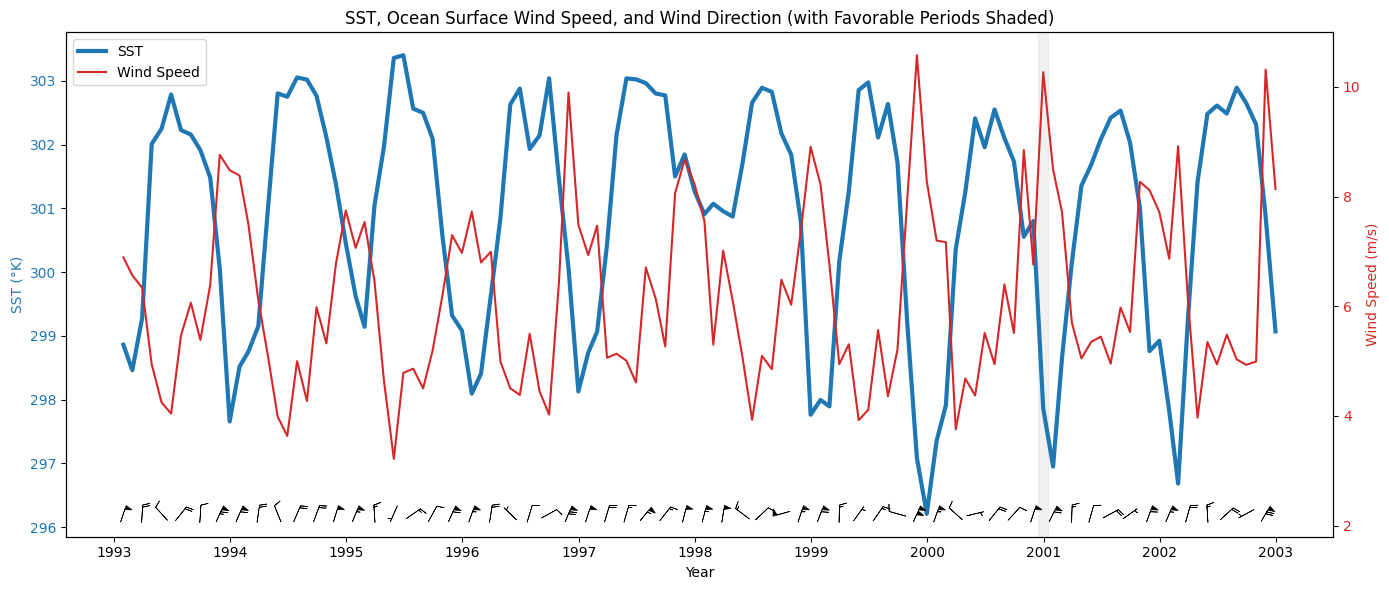

In [24]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# SST Plot
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°K)', color=color)
ax1.plot(sst_resample['time'], sst_resample, linewidth=3, color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color)

# Wind Speed Plot
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wind Speed (m/s)', color=color)
ax2.plot(wind_speed_resample['time'], wind_speed_resample, color=color, label='Wind Speed')
ax2.tick_params(axis='y', labelcolor=color)

# Add vertical shaded regions for favorable wind direction periods
for ft in favorable_times.values:
    ax1.axvspan(ft - np.timedelta64(15, 'D'), ft + np.timedelta64(15, 'D'),
                color='lightgray', alpha=0.3)

# Add wind barbs in lower panel (directional vectors)
# Normalize u and v components for visual length
barb_skip = 2  # Plot every nth point to reduce clutter if needed
barb_scale = 30  # Adjust scale for clarity

# Only plot barbs every few months
barb_time = u_resample.time.values[::barb_skip]
u_plot = u_resample.values[::barb_skip]
v_plot = v_resample.values[::barb_skip]

# Set position for barbs slightly below wind speed line
barb_y = np.full_like(u_plot, wind_speed_resample.min().item() - 1)

# Barbs on ax2 (wind axis)
ax2.barbs(barb_time, barb_y, u_plot, v_plot,
          length=5, pivot='middle', barb_increments=dict(half=1, full=2, flag=5),
          color='k', linewidth=0.5)

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("SST, Ocean Surface Wind Speed, and Wind Direction (with Favorable Periods Shaded)")
fig.tight_layout()
plt.show()